In [38]:
# Import necessary libraries
import os, re, time, urllib.parse, urllib.request, gzip, json
from collections import defaultdict, Counter

import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from networkx.readwrite import json_graph
from networkx.algorithms.community import louvain_communities
from networkx.algorithms.community.quality import modularity
import seaborn as sns
import statistics
import csv

#from sklearn.feature_extraction.text import TfidfVectorizer

from adjustText import adjust_text


In [73]:
# ==========  BUILD BIPARTITE GRAPH ==========

# Load data
df = pd.read_csv("festival_artist_data.csv")

G = nx.Graph()

# Add nodes and edges
for _, row in df.iterrows():
    festival_node = row['Festival_Year']
    artist_node = row['Artist_Name']
        # --- Extract festival name + year ---

    parts = festival_node.split("-")

    festival_name = parts[0]          # always first element
    year_str = parts[-1]              # always last element

    # --- Add festival-year node with attributes ---
    G.add_node(
        festival_node,
        bipartite="festival_year",
        festival=festival_name,
        year=year_str    
        )

    G.add_node(artist_node, bipartite="artist")

    G.add_edge(festival_node, artist_node)


# Convert graph to JSON serializable structure
data = json_graph.node_link_data(G)

with open("festival_network.json", "w", encoding="utf-8") as f:
    json.dump(data, f, ensure_ascii=False, indent=2)

print("Saved 'festival_network.json'")

Saved 'festival_network.json'


/Users/mittahage/.julia/conda/3/x86_64/lib/python3.10/site-packages/networkx/readwrite/json_graph/node_link.py:142: FutureWarning: 
The default value will be `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_data(G, edges="links") to preserve current behavior, or
  nx.node_link_data(G, edges="edges") for forward compatibility.
  warnings.warn(


In [40]:
#Open Network from GitHub JSON

base_url = "https://raw.githubusercontent.com/MittaHage/danish-music-festival-ecosystem/festival_network.json"

# Read JSON directly from GitHub
response = urllib.request.urlopen(base_url).read()
data = json.loads(response.decode("utf-8"))

# Convert to NetworkX graph
G = json_graph.node_link_graph(data)

HTTPError: HTTP Error 400: Bad Request

### basic analysis for bipartie

In [75]:
#basic analysis

num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()


festival_nodes = [n for n, d in G.nodes(data=True) if d.get('bipartite') == 'festival_year']
artist_nodes = [n for n, d in G.nodes(data=True) if d.get('bipartite') == 'artist']

print("Total nodes:", num_nodes)
print("Total edges:", num_edges)
print("Festival-Year nodes:", len(festival_nodes))
print("Artist nodes:", len(artist_nodes))


Total nodes: 7404
Total edges: 12095
Festival-Year nodes: 317
Artist nodes: 7087


In [76]:
artist_degrees = [G.degree(n) for n in artist_nodes]
festival_degrees = [G.degree(n) for n in festival_nodes]

print("Average artists per festival:", sum(festival_degrees) / len(festival_degrees))
print("Average festivals per artist:", sum(artist_degrees) / len(artist_degrees))

Average artists per festival: 38.154574132492115
Average festivals per artist: 1.7066459714971074


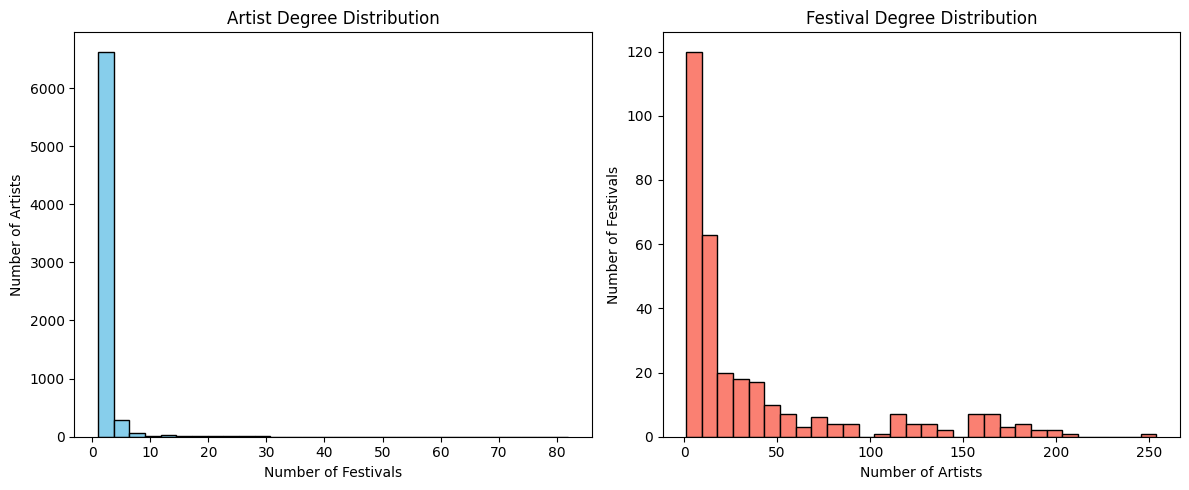

In [77]:
# plot degree distributions
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(artist_degrees, bins=30, color='skyblue', edgecolor='black')
plt.title('Artist Degree Distribution')
plt.xlabel('Number of Festivals')
plt.ylabel('Number of Artists') 
plt.subplot(1, 2, 2)
plt.hist(festival_degrees, bins=30, color='salmon', edgecolor='black')
plt.title('Festival Degree Distribution')
plt.xlabel('Number of Artists')
plt.ylabel('Number of Festivals')
plt.tight_layout()
plt.show()

In [78]:
components = list(nx.connected_components(G))
print("Number of connected components:", len(components))

Number of connected components: 8


In [79]:
#print each connected component sizes
for i, component in enumerate(components):
    print(f"Component {i+1} size: {len(component)}")

Component 1 size: 7387
Component 2 size: 3
Component 3 size: 2
Component 4 size: 2
Component 5 size: 3
Component 6 size: 2
Component 7 size: 3
Component 8 size: 2


In [80]:
# print what is included in components[i] where i goes from 2 to 8.
for i in range(1, 8):
    for node in components[i]:
        print(node)

tony-bennett
diana-krall
copenhagen-jazz-festival-2000
copenhagen-jazz-festival-2024
baryl
sérgio-mendes
copenhagen-jazz-festival-2006
nikolaj-nørlund
gwyneth-herbert
copenhagen-jazz-festival-2005
nanna-luders-jensen
groen-koncert-1984
christopher-singer
lagsus-with-emil-stabil-cisilia-vild-smith
groen-koncert-2015
groen-koncert-2016
lagsus-with-gilli-rapper


In [81]:
# copy of network and only save largest components

G_orginal = G.copy()
largest_component = max(components, key=len)
G = G_orginal.subgraph(largest_component).copy()

In [48]:
nx.shortest_path_length(G, source=festival_nodes[0])

if nx.is_connected(G):
    avg_path = nx.average_shortest_path_length(G)
    print("Average shortest path length:", avg_path)
else:
    print("Graph is not connected; average shortest path length is undefined.")



Average shortest path length: 4.552057498424406


Average shortest path length: 4.552057498424406


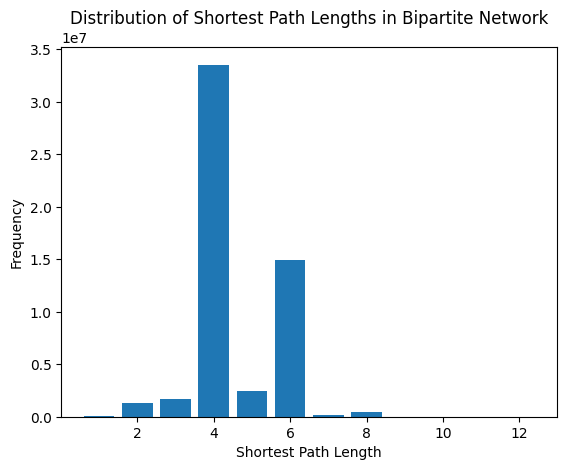

In [49]:
nx.shortest_path_length(G, source=festival_nodes[0])

if nx.is_connected(G):
    avg_path = nx.average_shortest_path_length(G)
    print("Average shortest path length:", avg_path)
else:
    print("Graph is not connected; average shortest path length is undefined.")


# Only works if the graph is connected
if not nx.is_connected(G):
    print("Graph is not fully connected. Using largest connected component.")
    largest_component = max(nx.connected_components(G), key=len)
    G_sub = G.subgraph(largest_component)
else:
    G_sub = G

# Calculate all shortest path lengths
path_lengths = dict(nx.all_pairs_shortest_path_length(G_sub))

# Flatten the distances into a single list (excluding 0 self-distances)
all_lengths = []

for source in path_lengths:
    for target in path_lengths[source]:
        if source != target:
            all_lengths.append(path_lengths[source][target])

# Count occurrences of each path length
length_counts = Counter(all_lengths)

# ========================
# PLOT DISTRIBUTION
# ========================

plt.figure()
plt.bar(length_counts.keys(), length_counts.values())
plt.xlabel("Shortest Path Length")
plt.ylabel("Frequency")
plt.title("Distribution of Shortest Path Lengths in Bipartite Network")
plt.show()

In [52]:
# ========================
# CENTRALITY MEASURES
# ========================

# DEGREE CENTRALITY:
# For artists → how many festivals they play (ubiquity)
# For festivals → size of lineup (scale)
degree = dict(G.degree())

# BETWEARNESS CENTRALITY:
# Measures how often a node lies on shortest paths between others.
# This identifies BRIDGES:
# Artists = connect different festival clusters
# Festivals = connect different artist communities
betweenness = nx.betweenness_centrality(G, normalized=True)

# CLOSENESS CENTRALITY:
# How close a node is to all others.
# High value = structurally central and well-positioned.
closeness = nx.closeness_centrality(G)


# ========================
# SPLIT INTO ARTISTS & FESTIVALS
# ========================

artists = []
festivals = []

number_of_nodes = G.number_of_nodes()

for node, data in G.nodes(data=True):
    entry = {
        "node": node,
        "degree": degree[node],
        "betweenness": betweenness[node],
        "closeness": closeness[node]
    }

    if data["bipartite"] == "artist":
        artists.append(entry)
    else:
        festivals.append(entry)


artist_df = pd.DataFrame(artists)
festival_df = pd.DataFrame(festivals)


In [53]:
# ========================
# SORT & DISPLAY TOP NODES
# ========================

def show_top(df, metric, title, n=10):
    print("\n" + title)
    print("-" * len(title))
    display = df.sort_values(by=metric, ascending=False).head(n)
    print(display[["node", metric]].to_string(index=False))


# ========================
# ARTIST ANALYSIS
# ========================

print("\n================ ARTIST CENTRALITY ================")

# Most frequently booked artists across festivals
show_top(
    artist_df,
    "degree",
    "Top Artists by Degree (played most festivals)",
)

# Artists that bridge different festival ecosystems
show_top(
    artist_df,
    "betweenness",
    "Top Artists by Betweenness (structural bridges)",
)

# Artists most centrally embedded in the network
show_top(
    artist_df,
    "closeness",
    "Top Artists by Closeness (most network-central)",
)


# ========================
# SUPERSTAR BRIDGING ARTISTS
# ========================

print("\n================ SUPERSTAR BRIDGING ARTISTS ================")
print("Artists who perform at the most festival-years, acting as structural glue between festivals.")
print("High degree here indicates artists most responsible for overlap and homogenisation.\n")

superstars = artist_df.sort_values(
    by="degree",
    ascending=False
).head(15)

print(superstars[["node", "degree", "betweenness"]].to_string(index=False))


# Optional: define a threshold for superstar status
threshold = superstars["degree"].mean()

print(f"\nArtists with degree above superstar threshold ({threshold:.2f} festival-years):")

bridging_elite = artist_df[artist_df["degree"] > threshold]
print(bridging_elite[["node", "degree"]].to_string(index=False))


# ========================
# FESTIVAL ANALYSIS
# ========================

print("\n================ FESTIVAL-YEAR CENTRALITY ================")

# Festivals with the largest lineups
show_top(
    festival_df,
    "degree",
    "Festivals by Degree (largest lineups)",
)

# Festivals that connect different artist communities
show_top(
    festival_df,
    "betweenness",
    "Festivals by Betweenness (structural hubs)",
)

# Festivals most central to the ecosystem
show_top(
    festival_df,
    "closeness",
    "Festivals by Closeness (most embedded)",
)



================ ARTIST CENTRALITY ================

Top Artists by Degree (played most festivals)
---------------------------------------------
                node  degree
               gnags      82
                tv-2      60
               d‐a‐d      59
             kashmir      48
  magtens-korridorer      43
kim-larsen-&-kjukken      42
           nik-&-jay      32
       thomas-helmig      31
       big-fat-snake      30
               d-a-d      29

Top Artists by Betweenness (structural bridges)
-----------------------------------------------
              node  betweenness
             gnags     0.061253
             d-a-d     0.040377
              tv-2     0.036170
           kashmir     0.024661
     c-v-j-rgensen     0.022588
     thomas-helmig     0.021858
  dizzy-mizz-lizzy     0.020019
johnny-madsen-band     0.016017
               mew     0.015858
            nephew     0.015272

Top Artists by Closeness (most network-central)
-------------------------------------

### Projectiled Festival-Year network

In [83]:
# ========== PROJECT TO FESTIVAL-YEAR NETWORK ==========
F = nx.Graph()
festival_nodes = [n for n, d in G.nodes(data=True) if d.get('bipartite') == 'festival_year']
artist_nodes   = [n for n, d in G.nodes(data=True) if d.get('bipartite') == 'artist']

# Add festival nodes
for node in festival_nodes:
    F.add_node(node, **G.nodes[node])

shared_artist_count = defaultdict(int)

# Count shared artists
for artist in artist_nodes:
    festivals = list(G.neighbors(artist))
    for i in range(len(festivals)):
        for j in range(i + 1, len(festivals)):
            f1, f2 = festivals[i], festivals[j]
            shared_artist_count[(f1, f2)] += 1

# Add edges with raw weight
for (f1, f2), weight in shared_artist_count.items():
    F.add_edge(f1, f2, weight=weight)

# ========== NORMALISATION (JACCARD SIMILARITY) ==========
for f1, f2 in F.edges():
    artists_f1 = set(G.neighbors(f1))
    artists_f2 = set(G.neighbors(f2))

    intersection = len(artists_f1 & artists_f2)
    union = len(artists_f1 | artists_f2)

    jaccard = intersection / union if union != 0 else 0

    F[f1][f2]['jaccard'] = jaccard


# ========== SAVE PROJECTED NETWORK ==========
projection_data = json_graph.node_link_data(F)

with open("festival_similarity_network.json", "w", encoding="utf-8") as f:
    json.dump(projection_data, f, ensure_ascii=False, indent=2)

print("Saved festival_similarity_network.json")


Saved festival_similarity_network.json


In [85]:
import itertools
import pandas as pd

# ========================
# GROUP FESTIVAL-YEAR NODES BY FESTIVAL (using attributes)
# ========================

festival_groups = {}

for node, data in F.nodes(data=True):   # Use F for clean festival-year nodes
    festival_name = data["festival"]    # attribute you added earlier
    year = int(data["year"])            # convert to int for sorting

    # Create structure: { festival_name : {year : node } }
    festival_groups.setdefault(festival_name, {})[year] = node


# ========================
# CALCULATE JACCARD OVER TIME
# ========================

overlap_results = []

for festival, years_dict in festival_groups.items():
    
    # Sort years chronologically
    years = sorted(years_dict.keys())
    
    # Compare all year-pairs for that festival
    for y1, y2 in itertools.combinations(years, 2):
        
        node1 = years_dict[y1]
        node2 = years_dict[y2]
        
        artists_1 = set(G.neighbors(node1))
        artists_2 = set(G.neighbors(node2))
        
        intersection = len(artists_1 & artists_2)
        union = len(artists_1 | artists_2)
        
        jaccard = intersection / union if union != 0 else 0
        
        overlap_results.append({
            "festival": festival,
            "year_1": y1,
            "year_2": y2,
            "jaccard_overlap": jaccard,
            "shared_artists": intersection,
            "total_unique_artists": union
        })


# ========================
# TURN INTO DATAFRAME FOR DISPLAY
# ========================

overlap_df = pd.DataFrame(overlap_results)


# ========================
# SHOW MOST & LEAST STABLE FESTIVALS
# ========================

print("\n===== Most Stylistically Stable Festivals =====")
print(overlap_df.sort_values("jaccard_overlap", ascending=False)
      .head(10)
      .to_string(index=False))


print("\n===== Most Dramatically Changing Festivals =====")
print(overlap_df.sort_values("jaccard_overlap", ascending=True)
      .head(10)
      .to_string(index=False))



===== Most Stylistically Stable Festivals =====
festival  year_1  year_2  jaccard_overlap  shared_artists  total_unique_artists
    nibe    2012    2013              1.0              11                    11
    nibe    2006    2022              1.0              11                    11
    nibe    2006    2024              1.0              11                    11
    nibe    2007    2008              1.0              11                    11
    nibe    2007    2009              1.0              11                    11
    nibe    2007    2010              1.0              11                    11
    nibe    2007    2011              1.0              11                    11
    nibe    2007    2012              1.0              11                    11
    nibe    2007    2013              1.0              11                    11
    nibe    2007    2014              1.0              11                    11

===== Most Dramatically Changing Festivals =====
 festival  year_1  ye

In [87]:
nibe_df = df[df["Festival_Year"].str.contains("nibe", case=False)]
print(nibe_df)


           Festival_Year       Artist_Name
9312  nibe-festival-2000             gnags
9313  nibe-festival-2000           kashmir
9314  nibe-festival-2000         love shop
9315  nibe-festival-2000  inside the whale
9316  nibe-festival-2000     johnny madsen
...                  ...               ...
9582  nibe-festival-2024        status quo
9583  nibe-festival-2024             d‐a‐d
9584  nibe-festival-2024       stig møller
9585  nibe-festival-2024        incorrect?
9586  nibe-festival-2024               api

[275 rows x 2 columns]


In [ ]:
import itertools

print("\n================ TEMPORAL OVERLAP PER FESTIVAL ================")
print("Jaccard similarity between different years of the SAME festival\n")

# Group festival-year nodes by festival name
festival_groups = {}

for node, data in G.nodes(data=True):
    if data["type"] == "festival_year":
        festival = data["festival"]
        year = data["year"]
        festival_groups.setdefault(festival, {})[year] = node


overlap_results = []

# Compute Jaccard overlaps per festival across years
for festival, years_dict in festival_groups.items():
    years = sorted(years_dict.keys())
    
    # Compare all year-pairs for that festival
    for y1, y2 in itertools.combinations(years, 2):
        node1 = years_dict[y1]
        node2 = years_dict[y2]

        artists_1 = set(G.neighbors(node1))
        artists_2 = set(G.neighbors(node2))

        intersection = len(artists_1 & artists_2)
        union = len(artists_1 | artists_2)
        jaccard = intersection / union if union != 0 else 0

        overlap_results.append({
            "festival": festival,
            "year_1": y1,
            "year_2": y2,
            "jaccard_overlap": jaccard,
            "shared_artists": intersection
        })


overlap_df = pd.DataFrame(overlap_results)


# ========================
# PRINT MOST & LEAST STABLE FESTIVALS
# ========================

print("\n--- Most Stable Festival Year-Pairs (highest overlap) ---")
print(overlap_df.sort_values(
    by="jaccard_overlap",
    ascending=False
).head(10).to_string(index=False))


print("\n--- Most Dramatically Changing Festival Year-Pairs (lowest overlap) ---")
print(overlap_df.sort_values(
    by="jaccard_overlap",
    ascending=True
).head(10).to_string(index=False))


# ========================
# AVERAGE STABILITY PER FESTIVAL
# ========================

print("\n--- Average Temporal Stability per Festival ---")
avg_stability = overlap_df.groupby("festival")["jaccard_overlap"].mean().sort_values(ascending=False)
print(avg_stability.to_string())


In [ ]:
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities

# ========================
# RUN COMMUNITY DETECTION
# ========================

# Use Jaccard similarity as weight for more meaningful clustering
communities = greedy_modularity_communities(F, weight="jaccard")

print(f"Number of communities detected: {len(communities)}\n")

# ========================
# DISPLAY COMMUNITIES
# ========================

for i, community in enumerate(communities, start=1):
    print(f"\nCommunity {i} (size {len(community)}):")
    for node in community:
        festival = F.nodes[node]['festival']
        year = F.nodes[node]['year']
        print(f"  - {festival} {year}")


In [ ]:
from networkx.algorithms.community.quality import modularity

mod = modularity(F, communities, weight="jaccard")
print("Modularity score:", mod)


### Genre analysis

In [ ]:
# Show sample of artist genre data
for node, data in G.nodes(data=True):
    if data["type"] == "artist" and "genre" in data:
        print(node, "->", data["genre"])
        break


In [ ]:
from collections import Counter

genre_counter = Counter()

for node, data in G.nodes(data=True):
    if data["type"] == "artist" and "genre" in data:
        genres = data["genre"]
        if isinstance(genres, list):
            for g in genres:
                genre_counter[g] += 1
        else:
            genre_counter[genres] += 1

print("\n===== MOST COMMON GENRES IN NETWORK =====")
for genre, count in genre_counter.most_common(20):
    print(f"{genre}: {count}")


In [ ]:
festival_genre_profiles = {}

for node, data in G.nodes(data=True):
    if data["type"] == "festival_year":
        festival = data["festival"]
        year = data["year"]
        key = f"{festival}_{year}"
        
        genre_counter = Counter()
        artists = G.neighbors(node)
        
        for artist in artists:
            artist_data = G.nodes[artist]
            if "genre" in artist_data:
                genres = artist_data["genre"]
                if isinstance(genres, list):
                    for g in genres:
                        genre_counter[g] += 1
        
        festival_genre_profiles[key] = genre_counter


In [ ]:
print("\n===== GENRE PROFILE FOR A FESTIVAL-YEAR =====")
print("Roskilde_2022:", festival_genre_profiles.get("Roskilde_2022"))


In [ ]:
import math

def shannon_entropy(counter):
    total = sum(counter.values())
    entropy = 0
    for count in counter.values():
        p = count / total
        entropy -= p * math.log2(p)
    return entropy

festival_genre_diversity = {}

for festival, counter in festival_genre_profiles.items():
    festival_genre_diversity[festival] = shannon_entropy(counter)

print("\n===== MOST GENRE-DIVERSE FESTIVALS =====")
for f, v in sorted(festival_genre_diversity.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f, round(v, 3))
